# Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, classification_report

# Load Dataset

In [3]:
# Directories
data_dir = '../data'
processed_data_dir = f'{data_dir}/processed'

# Dataset name and path
dataset_name = 'brfss_heart_2022.csv'
dataset_path = f'{processed_data_dir}/{dataset_name}'

# Load dataframe
df = pd.read_csv(dataset_path)
df

,had_heart_attack,age_category,alcohol_drinker,bmi,chest_scan,covid_positive,difficulty_concentrating,difficulty_dressing_bathing,difficulty_errands,difficulty_hearing,...,last_checkup_time,mental_health_days,physical_activities,physical_health_days,pneumovax_ever,race_ethnicity_category,removed_teeth,sleep_hours,smoker_status,tetanus_last10_tdap
0,0,0.075709,0,27.99,0,0.058272,0,0,0,0,...,0.062507,0.0,1,4.0,1,0.057635,0.028827,9.0,0.082050,0.040204
1,0,0.093510,0,30.13,0,0.058441,0,0,0,0,...,0.062551,0.0,1,0.0,1,0.057738,0.028633,6.0,0.081592,0.062026
2,0,0.114254,1,31.66,1,0.048924,0,0,0,0,...,0.062452,0.0,0,0.0,1,0.057837,0.113620,8.0,0.081567,0.059106
3,0,0.135313,0,31.32,0,0.049145,0,0,0,0,...,0.062507,0.0,1,5.0,1,0.057635,0.028827,9.0,0.037141,0.058362
4,0,0.137355,0,33.07,0,0.058441,0,0,0,0,...,0.062551,15.0,1,3.0,1,0.057738,0.058593,5.0,0.037006,0.058032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246017,0,0.057494,1,32.28,0,0.058433,0,0,0,0,...,0.025271,0.0,1,0.0,0,0.057837,0.028788,6.0,0.037285,0.062477
246018,0,0.004168,0,24.34,0,0.047966,0,0,0,0,...,0.062581,7.0,1,0.0,0,0.046604,0.028423,7.0,0.036984,0.058493
246019,0,0.074250,1,29.86,0,0.048924,0,0,0,0,...,0.062452,15.0,1,0.0,1,0.062470,0.058299,7.0,0.037285,0.062477
246020,0,0.035057,0,28.66,0,0.058272,0,0,0,0,...,0.062507,2.0,1,2.0,0,0.046833,0.028827,7.0,0.037141,0.062332


# Import Models (optional)

In [4]:
from pickle import load

model_dir = '../models'

lr_name = 'logistic_regression.pkl'
lr_path = f'{model_dir}/{lr_name}'
rf_name = 'random_forest_classifier.pkl'
rf_path = f'{model_dir}/{rf_name}'


with open(lr_path, "rb") as f:
    lr_model = load(f)
with open(rf_path, "rb") as f:
    rf_model = load(f)

# Helpers

In [11]:
# Calculates evaluation metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_pr = average_precision_score(y_true, y_pred)
    return accuracy, precision, recall, f1, auc_pr

# Displays evaluation metrics
def display_metrics(accuracy, precision, recall, f1, auc_pr):
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'AUC-PR: {auc_pr}')

# Calculates and displays training time
def record_training_time(start_time, end_time):
    training_time = end_time - start_time
    print(f'Training Time: {training_time:.4f} seconds')

# Global Variables

In [8]:
num_features = ['bmi', 'mental_health_days', 'physical_health_days', 'sleep_hours']

X = df.drop('had_heart_attack', axis=1) # Features
y = df['had_heart_attack']              # Target

RANDOM_STATE = 42

# Logistic Regression

Train

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Scaler for numerical columns
preprocessor = ColumnTransformer(
    transformers=[('num', RobustScaler(), num_features)],
    remainder='passthrough'
)

# Create pipeline
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter=100, class_weight='balanced', random_state=RANDOM_STATE))
    ]
)

# Hyperparameter grid
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100] # Inverse of regularization strength
}

# Use GridSearchCV for hyperparameter tuning
logistic_grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=10,
    scoring='average_precision',
    n_jobs=-1
)

# Fit GridSearchCV
start_time = time.time()
logistic_grid_search.fit(X_train, y_train)
end_time = time.time()
record_training_time(start_time, end_time)

# Best hyperparameters
print(f'Best parameters: {logistic_grid_search.best_params_}')

# Extract best model
best_model = logistic_grid_search.best_estimator_

Training Time: 83.7182 seconds
Best parameters: {'model__C': 0.1}


c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluate

Train Metrics:
Accuracy: 0.8438041429348074
Precision: 0.22489583045889788
Recall: 0.7544200684994908
F1 Score: 0.3464988733472216
AUC-PR: 0.1831454544869554

Test Metrics:
Accuracy: 0.8439183009856722
Precision: 0.21943085815918187
Recall: 0.75
F1 Score: 0.3395252837977296
AUC-PR: 0.17794576835264522

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     46573
           1       0.22      0.75      0.34      2632

    accuracy                           0.84     49205
   macro avg       0.60      0.80      0.63     49205
weighted avg       0.94      0.84      0.88     49205



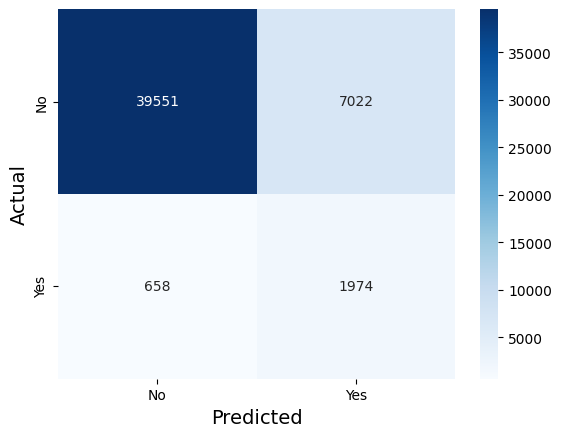

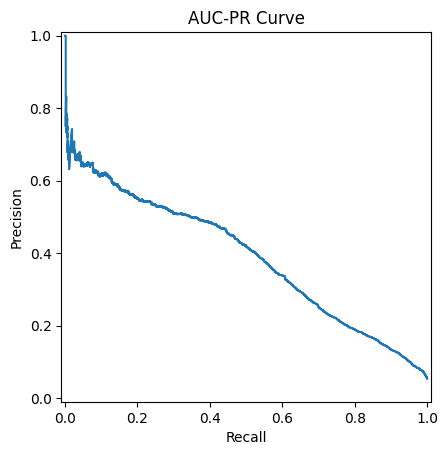

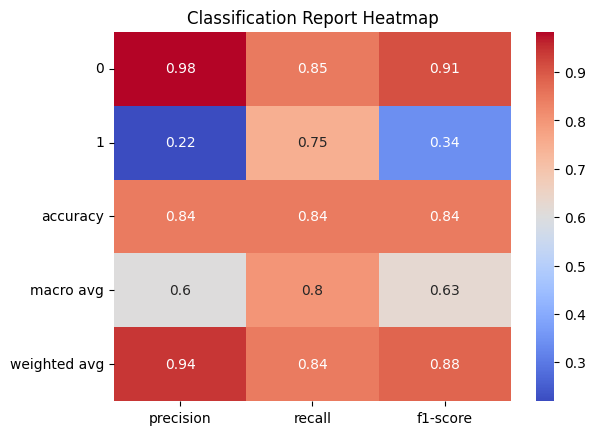

In [ ]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Metrics
acc, prec, rec, f1, auc_pr = calculate_metrics(y_train, y_train_pred)
print('Train Metrics:')
display_metrics(acc, prec, rec, f1, auc_pr)

acc, prec, rec, f1, auc_pr = calculate_metrics(y_test, y_test_pred)
print('\nTest Metrics:')
display_metrics(acc, prec, rec, f1, auc_pr)
lr_metrics = [acc, prec, rec, f1, auc_pr]

print(f'\nClassification Report:\n{classification_report(y_test, y_test_pred)}')



# Visualizations
from sklearn.metrics import confusion_matrix, precision_recall_curve, PrecisionRecallDisplay

y_proba = best_model.predict_proba(X_test)
y_proba_positive = y_proba[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

# PR Curve
lr_precision, lr_recall, thresholds = precision_recall_curve(y_test, y_proba_positive)
PrecisionRecallDisplay(precision=lr_precision, recall=lr_recall).plot()
plt.title('AUC-PR Curve')
plt.show()

# Classification Report Heatmap
report = classification_report(y_test, y_test_pred, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='coolwarm')
plt.title('Classification Report Heatmap')
plt.show()

# Random Forest

Tuning

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Hyperparameter grid
param_grid = {
    'n_estimators': [200, 250, 300]
}

# Use GridSearchCV to perform cross-validated hyperparameter tuning. This finds the best hyperparameters (n_estimators, max_features).
rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,
    scoring='auc_pr',
    n_jobs=-1
)

# Fit GridSearchCV
start_time = time.time()
rf_grid_search.fit(X_train, y_train)
end_time = time.time()
record_training_time(start_time, end_time)

# Best hyperparameters
print(f'Best parameters: {rf_grid_search.best_params_}')

# Extract best model
best_rf = rf_grid_search.best_estimator_

c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
8 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\6006CEM Machine Learning and Related Applications\Assignment\6006cem-ml\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\wztho\Desktop\College Folder\Degree\Semester 4 (AUG2024)\60

Training Time: 1544.0205 seconds
Best parameters: {'n_estimators': 200}


Evaluate

In [ ]:
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

acc, prec, rec, f1, auc_pr = calculate_metrics(y_train, y_train_pred)
print('Train Metrics:')
display_metrics(acc, prec, rec, f1, auc_pr)

acc, prec, rec, f1, auc_pr = calculate_metrics(y_test, y_test_pred)
print('\nTest Metrics:')
display_metrics(acc, prec, rec, f1, auc_pr)

print(f'\nClassification Report:\n{classification_report(y_test, y_test_pred)}')

Retrain

In [7]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

Evaluate

Train Metrics:
Accuracy: 0.9999949191380826
Precision: 0.9999074416882636
Recall: 1.0
F1 Score: 0.9999537187022725
AUC-PR: 0.9999074416882636

Test Metrics:
Accuracy: 0.9486027842698913
Precision: 0.5898778359511344
Recall: 0.128419452887538
F1 Score: 0.2109204368174727
AUC-PR: 0.12237306728870302

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     46573
           1       0.59      0.13      0.21      2632

    accuracy                           0.95     49205
   macro avg       0.77      0.56      0.59     49205
weighted avg       0.93      0.95      0.93     49205



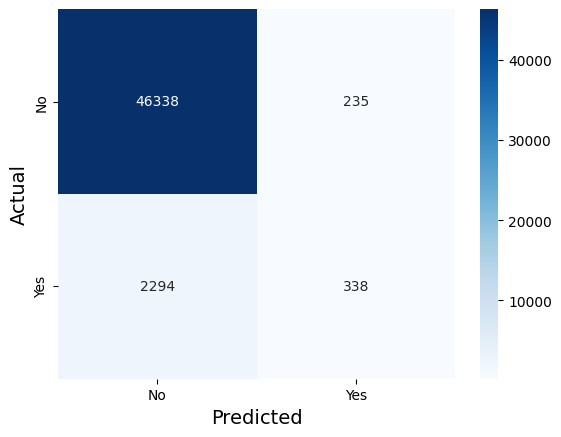

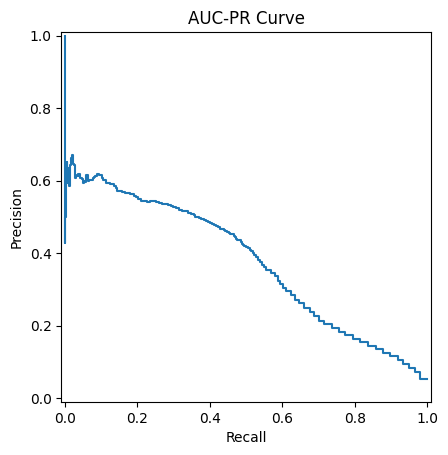

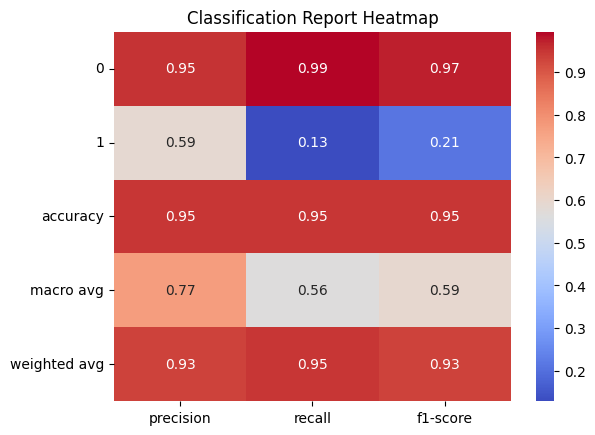

In [13]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Metrics
acc, prec, rec, f1, auc_pr = calculate_metrics(y_train, y_train_pred)
print('Train Metrics:')
display_metrics(acc, prec, rec, f1, auc_pr)

acc, prec, rec, f1, auc_pr = calculate_metrics(y_test, y_test_pred)
print('\nTest Metrics:')
display_metrics(acc, prec, rec, f1, auc_pr)
rf_metrics = [acc, prec, rec, f1, auc_pr]

print(f'\nClassification Report:\n{classification_report(y_test, y_test_pred)}')



# Visualizations
from sklearn.metrics import confusion_matrix, precision_recall_curve, PrecisionRecallDisplay

y_proba = rf.predict_proba(X_test)
y_proba_positive = y_proba[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

# PR Curve
rf_precision, rf_recall, thresholds = precision_recall_curve(y_test, y_proba_positive)
PrecisionRecallDisplay(precision=rf_precision, recall=rf_recall).plot()
plt.title('AUC-PR Curve')
plt.show()

# Classification Report Heatmap
report = classification_report(y_test, y_test_pred, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='coolwarm')
plt.title('Classification Report Heatmap')
plt.show()

# Comparison

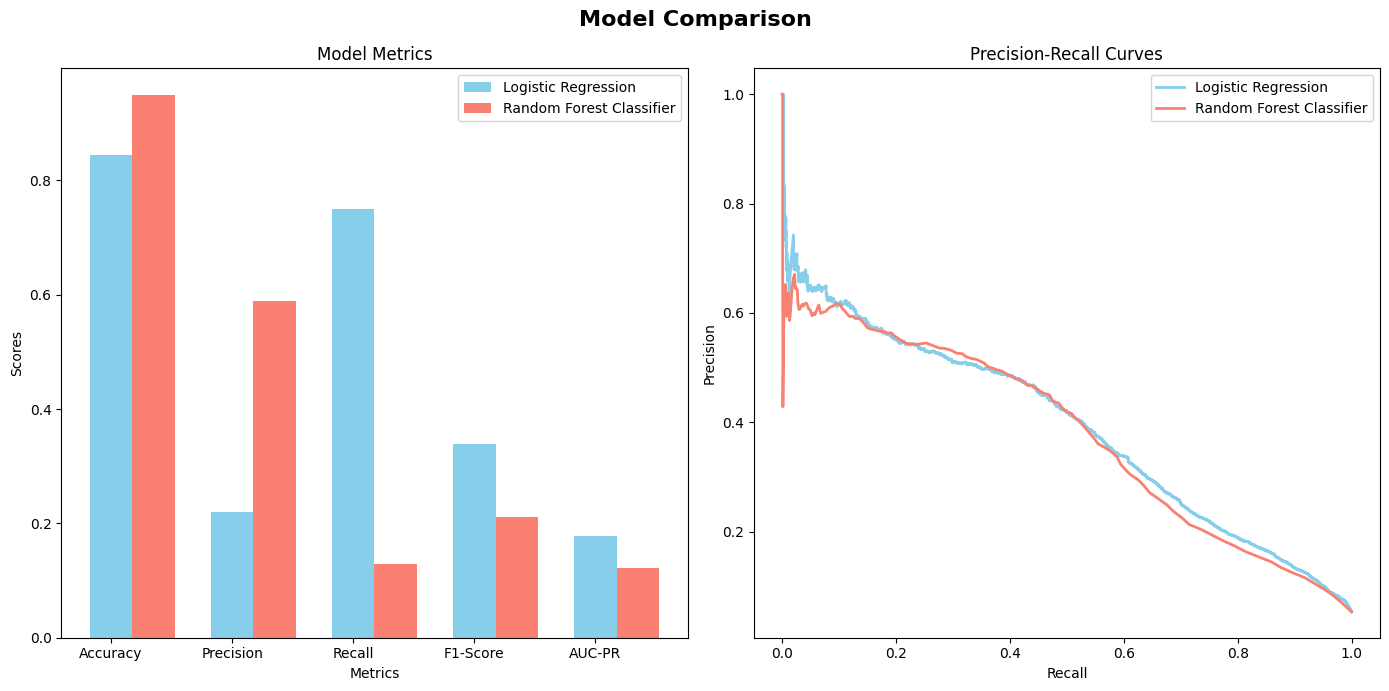

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
axes = axes.flatten()

# Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-PR']
pos = np.arange(len(metrics))
bar_width = 0.35

ax1 = axes[0]
ax1.bar(pos, lr_metrics, bar_width, label='Logistic Regression', color='skyblue')
ax1.bar(pos + bar_width, rf_metrics, bar_width, label='Random Forest Classifier', color='salmon')
ax1.set_xlabel('Metrics')
ax1.set_ylabel('Scores')
ax1.set_title('Model Metrics')
ax1.set_xticks(pos)
ax1.set_xticklabels(metrics)
ax1.legend()

# AUC-PR
ax2 = axes[1]
ax2.plot(lr_recall, lr_precision, label='Logistic Regression', color='skyblue', linestyle='-', linewidth=2)
ax2.plot(rf_recall, rf_precision, label='Random Forest Classifier', color='salmon', linestyle='-', linewidth=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()

plt.tight_layout()
plt.show()

# Export

In [ ]:
from pickle import dump

model_dir = '../models'

lr_name = 'logistic_regression.pkl'
lr_path = f'{model_dir}/{lr_name}'
rf_name = 'random_forest_classifier.pkl'
rf_path = f'{model_dir}/{rf_name}'

with open(lr_path, "wb") as f:
    dump(best_model, f, protocol=5)
with open(rf_path, "wb") as f:
    dump(rf, f, protocol=5)